In [1]:
import sys
import os
import six
sys.path.insert(0,"../")
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad
from utils import lddmm_utils, mesh_processing, sph_utils
import open3d as o3d

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyssht

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_data(file):
    mesh = o3d.io.read_triangle_mesh(file)
    V, F, Rho = mesh_processing.getDataFromMesh(mesh)
    return(V,F,Rho)

V,F,Rho = get_data("../data/test_data/bunny.ply")

sphere = tri.creation.uv_sphere(count=[64, 64])
mesh = tri.Trimesh(V,F)
new_mesh_V, new_mesh_F = mesh_processing.decimate_mesh(V,F,target = 13904)

print("mesh: ", new_mesh_V[:,0].shape)
print("sphere: ", sphere.vertices.shape)

mesh:  (8128,)
sphere:  (8128, 3)


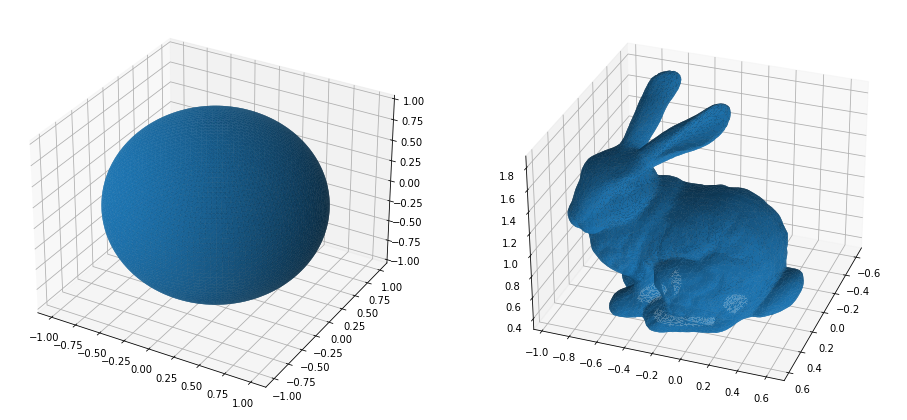

In [3]:
(r_mesh, theta_mesh, phi_mesh) = pyssht.cart_to_spherical(10*new_mesh_V[:,0], 10*new_mesh_V[:,1], 10*new_mesh_V[:,2])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(x, y, triangles=sphere.faces, Z=z)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(10*new_mesh_V[:,2], 10*new_mesh_V[:,0], triangles=new_mesh_F, Z=10*new_mesh_V[:,1])
ax2.view_init(30, 20)

plt.show()

In [140]:
n = 49
my_basis = sph_utils.SphHarmBasis(n_coeffs=n) # NEED TO BE A SQUARE NUMBER

def my_sphere_function_r(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

my_coeffs_r = my_basis.sph_harm_transform(my_sphere_function_r)
my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)

my_reconstr_function_r = my_basis.sph_harm_reconstruct(my_coeffs_r)
my_reconstr_function_theta = my_basis.sph_harm_reconstruct(my_coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(my_coeffs_phi)

In [141]:
f_recons_r = my_reconstr_function_r(theta,phi)
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)

In [142]:
(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)
mesh_recons = tri.convex.convex_hull(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T)

Text(0.5, 0.92, 'Unit sphere')

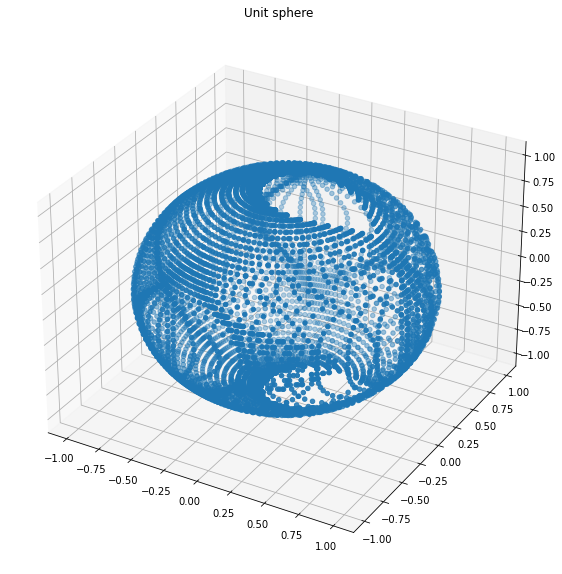

In [143]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax1.set_title("Unit sphere")

In [144]:
import torch
import time
from torch.autograd import grad

# torch type and device
use_cuda = torch.cuda.is_available()
torchdeviceId = torch.device("cuda:0") if use_cuda else "cpu"
torchdtype = torch.float32

VS = np.hstack((my_coeffs_r, my_coeffs_theta, my_coeffs_phi))
VT = new_mesh_V*10
q0 = torch.from_numpy(VS)
q0 = q0.clone().detach().to(dtype=torchdtype, device=torchdeviceId).requires_grad_(True)
#p0 = torch.from_numpy(np.zeros(q0.shape[0]))

In [145]:
### loss
def loss(q0):
    
    coeffs_r, coeffs_theta, coeffs_phi = q0[:n], q0[n:2*n], q0[2*n:]
    
    my_reconstr_function_r = my_basis.sph_harm_reconstruct(coeffs_r)
    my_reconstr_function_theta = my_basis.sph_harm_reconstruct(coeffs_theta)
    my_reconstr_function_phi = my_basis.sph_harm_reconstruct(coeffs_phi)
    
    f_recons_r = my_reconstr_function_r(theta,phi)
    f_recons_theta = my_reconstr_function_theta(theta,phi)
    f_recons_phi = my_reconstr_function_phi(theta,phi)
    (x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)
    
    return(np.linalg.norm(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T - VT))

In [153]:
VS.shape

(147,)

In [154]:
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
lw = [0] * 3*n
up = [5] * 3*n

In [155]:
#res = minimize(loss, VS, method='BFGS', tol=1e-5)
res = dual_annealing(loss, bounds=list(zip(lw, up)), x0 = VS)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tbesnier/projects/manimesh/config/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_457/2929850411.py", line 2, in <cell line: 2>
    res = dual_annealing(loss, bounds=list(zip(lw, up)), x0 = VS)
  File "/home/tbesnier/projects/manimesh/config/lib/python3.8/site-packages/scipy/optimize/_dual_annealing.py", line 693, in dual_annealing
    val = strategy_chain.run(i, temperature)
  File "/home/tbesnier/projects/manimesh/config/lib/python3.8/site-packages/scipy/optimize/_dual_annealing.py", line 299, in run
    e = self.func_wrapper.fun(x_visit)
  File "/home/tbesnier/projects/manimesh/config/lib/python3.8/site-packages/scipy/optimize/_dual_annealing.py", line 382, in fun
    return self.func(x, *self.args)
  File "/tmp/ipykernel_457/2668627226.py", line 11, in loss
    f_recons_theta = my_reconstr_function_theta(theta,phi)
  Fil

In [ ]:
loss(res.x)

In [ ]:
res.x

In [136]:
coeffs_r, coeffs_theta, coeffs_phi = res.x[:n], res.x[n:2*n], res.x[2*n:]
my_reconstr_function_r = my_basis.sph_harm_reconstruct(coeffs_r)
my_reconstr_function_theta = my_basis.sph_harm_reconstruct(coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(coeffs_phi)
f_recons_r = my_reconstr_function_r(theta,phi)
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)
(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)

Text(0.5, 0.92, 'Shape reconstr')

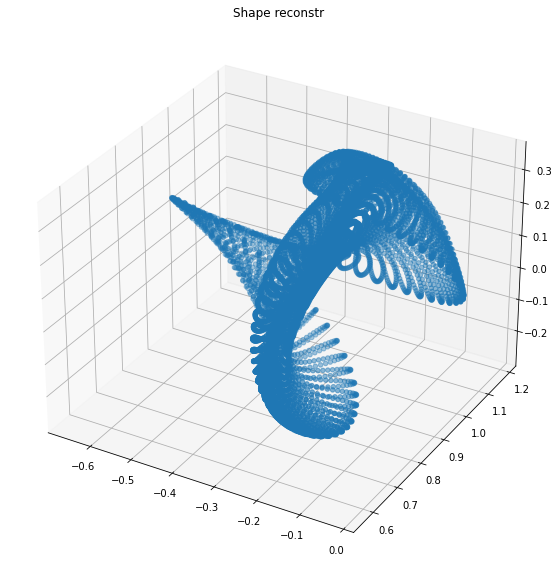

In [137]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax1.set_title("Shape reconstr")

In [41]:
optimizer = torch.optim.LBFGS([q0], max_eval=10, max_iter=10)
print("performing optimization...")
start = time.time()

def closure():
    optimizer.zero_grad()
    L = loss(q0)
    print("loss", L.detach().cpu().numpy()[0])
    L.backward(retain_graph=True)
    return L

for i in range(10):
    print("it ", i, ": ", end="")
    optimizer.step(closure)

print("Optimization (L-BFGS) time: ", round(time.time() - start, 2), " seconds")

performing optimization...
it  0 : loss 89.95886
it  1 : loss 89.95886
it  2 : loss 89.95886
it  3 : loss 89.95886
it  4 : loss 89.95886
it  5 : loss 89.95886
it  6 : loss 89.95886
it  7 : loss 89.95886
it  8 : loss 89.95886
it  9 : loss 89.95886
Optimization (L-BFGS) time:  1.64  seconds
